## Run a single example of the calibration for a certain set of parameters

In [1]:
include("ms_calibration.jl")

# demonstrate that we have achieve >99.99% fidelity with ideal parameters
detuning_khz = 10
pi_time_μs = 5
ac_stark_shift_hz = 35
θ = HamiltonianParameters(detuning_khz, pi_time_μs, ac_stark_shift_hz)
@time ms_fidelity(θ, θ)

 39.877746 seconds (81.63 M allocations: 4.171 GiB, 4.74% gc time)


0.9999678828839386

In [2]:
include("ms_calibration.jl")
import PyPlot
const plt = PyPlot;

detuning_khz = 10
pi_time_μs = 5
ac_stark_shift_hz = 35
θ = HamiltonianParameters(detuning_khz, pi_time_μs, ac_stark_shift_hz)

initial_guess = HamiltonianParameters(detuning_khz*0.75, pi_time_μs*0.75, ac_stark_shift_hz*1.0)
tspan_ideal = 0:0.1:200

N = 50
tspan_experiment = 0:20:200

@time res = ms_calibration(θ, initial_guess, N, tspan_ideal, tspan_experiment)

ideal = res["ideal_curve"]
ideal_fit_params = res["ideal_fit_params"]
experimental = res["experimental_data"]
learned = res["learned_curve"]
learned_fit_params = res["learned_fit_params"]

error = (
    ideal_fit_params.detuning_khz - learned_fit_params.detuning_khz,
    ideal_fit_params.pi_time_μs - learned_fit_params.pi_time_μs,
    ideal_fit_params.ac_stark_shift_hz - learned_fit_params.ac_stark_shift_hz,
)
    
relative_error = (
    error[1] / ideal_fit_params.detuning_khz,
    error[2] / ideal_fit_params.pi_time_μs,
    error[3] / ideal_fit_params.ac_stark_shift_hz,
)

  5.482384 seconds (37.99 M allocations: 1.241 GiB, 7.58% gc time)


(-0.00501603789912366, 0.021638710973659415, 0.47603273134882124)

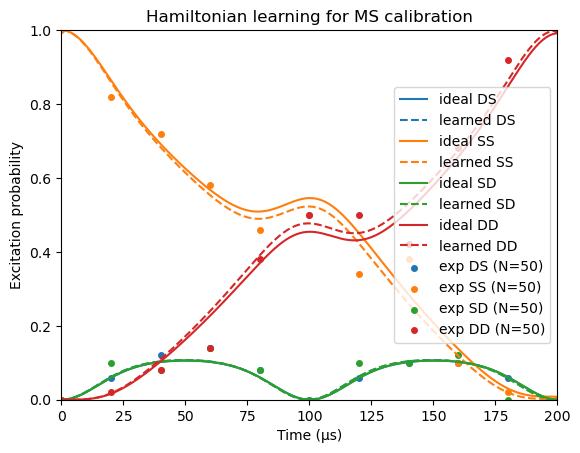

ideal fit parameters HamiltonianParameters(10.0, 5.0, 35.0)
learned fit parameters HamiltonianParameters(10.050160378991237, 4.891806445131703, 18.338854402791256)
fit parameters relative error=(-0.00501603789912366, 0.021638710973659415, 0.47603273134882124)


In [3]:
plt.figure()
for state in keys(experimental[1])
    plt.plot(tspan_ideal, getindex.(ideal, state), "-", label="ideal $state")
    plt.plot(tspan_ideal, getindex.(learned, state), "--", label="learned $state", color=plt.gca().lines[end].get_color())
    plt.scatter(tspan_experiment, getindex.(experimental, state), label="exp $state (N=$(N))", s=16, color=plt.gca().lines[end].get_color())
end

println("ideal fit parameters $(ideal_fit_params)")
println("learned fit parameters $(learned_fit_params)")
println("fit parameters relative error=$(relative_error)")

plt.title("Hamiltonian learning for MS calibration")
plt.xlim(tspan_ideal[1], tspan_ideal[end])
plt.ylim(0, 1)
plt.xlabel("Time (μs)")
plt.ylabel("Excitation probability")
plt.legend(loc="center right");

## Test the average error of the technique as a function of N

In [4]:
include("ms_calibration.jl")

n_repetitions = 20
n_shots_list = [5, 10, 25, 50, 100, 250, 500, 1000]

tspan_ideal = 0:0.1:200
tspan_experiment = 0:20:200

relative_error_results = Dict()
fidelities = Dict()
for n_shots in n_shots_list 
    print("Running for n_shots=$(n_shots)")
    relative_error_results[n_shots] = []
    fidelities[n_shots] = []
    for i = 1:n_repetitions
        print(".")
        actual_detuning_khz = 10
        actual_pi_time_μs = 5
        actual_ac_stark_shift_hz = 35
        θ = HamiltonianParameters(actual_detuning_khz, actual_pi_time_μs, actual_ac_stark_shift_hz)
        initial_guess = HamiltonianParameters(actual_detuning_khz*0.75, actual_pi_time_μs*0.75, ac_stark_shift_hz*1.0)
        res = ms_calibration(
            θ,
            initial_guess,
            n_shots,
            tspan_ideal,
            tspan_experiment)

        ideal = res["ideal_curve"]
        ideal_fit_params = res["ideal_fit_params"]
        experimental = res["experimental_data"]
        learned = res["learned_curve"]
        learned_fit_params = res["learned_fit_params"]

        # calculate relative error in learned fit parameters
        error = (
            ideal_fit_params.detuning_khz - learned_fit_params.detuning_khz,
            ideal_fit_params.pi_time_μs - learned_fit_params.pi_time_μs,
            ideal_fit_params.ac_stark_shift_hz - learned_fit_params.ac_stark_shift_hz,
        )
        relative_error = (
            error[1] / ideal_fit_params.detuning_khz,
            error[2] / ideal_fit_params.pi_time_μs,
            error[3] / ideal_fit_params.ac_stark_shift_hz,
        )
        push!(relative_error_results[n_shots], relative_error)
        
        # calculate the resulting error in MS-gate fidelity
        fidelity = ms_fidelity(θ, learned_fit_params)
        push!(fidelities[n_shots], fidelity)
    end
    println(" complete!")
end

Running for n_shots=5.................... complete!
Running for n_shots=10.................... complete!
Running for n_shots=25.................... complete!
Running for n_shots=50.................... complete!
Running for n_shots=100.................... complete!
Running for n_shots=250.................... complete!
Running for n_shots=500.................... complete!
Running for n_shots=1000.................... complete!


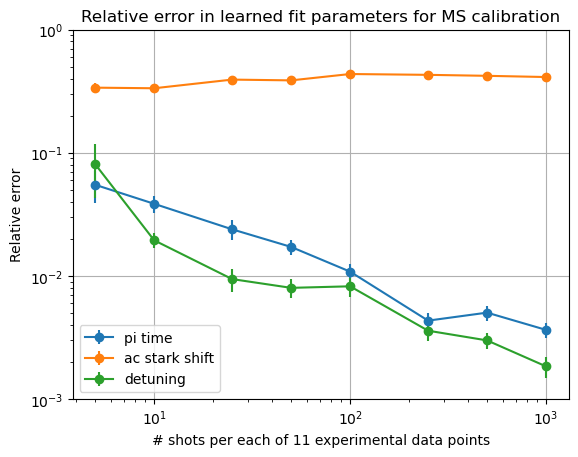

In [5]:
import PyPlot
const plt = PyPlot;
import Statistics

plt.figure()

error_plots = Dict(1 => "detuning", 2 => "pi time", 3 => "ac stark shift")

for (index, label) in error_plots
    means = []
    stderrs = []
    for n_shots in n_shots_list
        relative_errors = [abs(errors[index]) for errors in relative_error_results[n_shots]]
        push!(means, mean(relative_errors))
        push!(stderrs, Statistics.std(relative_errors) / sqrt(length(relative_errors)))
    end
    plt.errorbar(x=n_shots_list, y=means, yerr=stderrs, linestyle="-", marker="o", label=label)
end

plt.title("Relative error in learned fit parameters for MS calibration")
plt.ylim(1e-3, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# shots per each of $(length(tspan_experiment)) experimental data points")
plt.ylabel("Relative error")
plt.legend()
plt.grid();

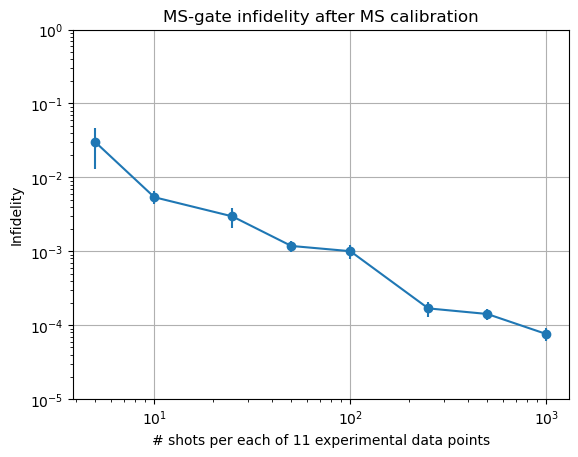

In [6]:
import PyPlot
const plt = PyPlot;
using Statistics

fidelity_means = []
fidelity_stderrs = []
for n_shots in n_shots_list
    push!(fidelity_means, mean(fidelities[n_shots]))
    push!(fidelity_stderrs, Statistics.std(fidelities[n_shots]) / sqrt(length(fidelities[n_shots])))
end

plt.figure()
plt.errorbar(x=n_shots_list, y=1 .- fidelity_means, yerr=fidelity_stderrs, linestyle="-", marker="o")

plt.title("MS-gate infidelity after MS calibration")
plt.ylim(1e-5, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# shots per each of $(length(tspan_experiment)) experimental data points")
plt.ylabel("Infidelity")
plt.grid();

## Print the raw result data

In [7]:
print(relative_error_results)

Dict{Any,Any}(25 => Any[(9.474253094730046e-5, -0.016369901997445167, 0.41919894843486327), (0.009336706883852486, -0.022076500591195015, 0.4208700944277059), (-0.004719206345374083, 0.04422615557651053, 0.3541526432197015), (-0.01220708575552365, 0.04433678324701642, 0.3766182302377868), (0.0015968557677270567, 0.013449559253766985, 0.40367941620907205), (0.013781296808178745, 0.031189381852000864, 0.32952210614208294), (-7.154864858751608e-5, 0.047321366528051814, 0.3109751856127351), (-0.001446665020242577, -0.007621827109124091, 0.452843621269123), (0.001970903628381748, -0.005699379564689977, 0.4337219823007721), (0.0316449117610416, -0.050456633901760736, 0.3839206365310985), (-0.020063944434755676, 0.02496203366026979, 0.4109561105193671), (0.004024296938958472, 0.008643219491388087, 0.39133302043006274), (-0.0036130366790583677, 0.004043351020911601, 0.4659301906099819), (0.018838879094817074, -0.0012062034544172207, 0.31975736298596963), (0.010156597504003351, 0.00960806625088

 (-0.00295837611455223, 0.0013110603936517863, 0.44856059381328733), (-0.0008163495836058133, 0.0022127503874653344, 0.42302349280864787), (0.005788915821637453, -0.002454088369654173, 0.3959337661632162), (-0.0012802377988800017, 0.006681536914453545, 0.4064518933230205), (0.0023557090399528137, -0.002424125847487346, 0.3739897216541033), (0.0010570523566512335, -0.00490063687488842, 0.48187719359028125), (0.0014166708868433632, 0.0025912333850959257, 0.4235116414127613), (0.00034288498886994037, 0.0023377542744732692, 0.4048019773803098), (-0.00020021184751026767, -0.007684616705945757, 0.4417307906946743)])

In [8]:
print(fidelities)

Dict{Any,Any}(25 => Any[0.9993373042494499, 0.9992376034350097, 0.9961583996715726, 0.9966871742293759, 0.9994537536063797, 0.9946814211464089, 0.9948387113319714, 0.999778003432932, 0.9999602578296961, 0.9941636748038992, 0.997874779112238, 0.9995726537700587, 0.999907982319751, 0.9977510384572237, 0.9987107242920678, 0.9905159566228028, 0.9995948646168336, 0.9995291617573703, 0.998533139874251, 0.9843743846975335],10 => Any[0.993119409710396, 0.9963413770770156, 0.9847917148345516, 0.9936345328731184, 0.9831566251877049, 0.9981186214184489, 0.9964648394261202, 0.9929139028284111, 0.996368926002637, 0.9986265583835927, 0.9865707663501834, 0.9928772585946107, 0.9981832414006513, 0.9994696417728182, 0.9986843974621417, 0.9917953669270577, 0.9984092258410087, 0.9946932513977403, 0.9995554065416574, 0.998454402970653],50 => Any[0.9962218700489525, 0.9980078726367347, 0.9994377863962774, 0.9982264453941634, 0.9990974331192897, 0.9993049703315755, 0.9988124000851829, 0.9993883179759739, 0.9